In [1]:
# necessary packages #

#using Pkg
#Pkg.add("Distances")
using Distributions
using Random
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter
using JLD2

In [2]:
include("../../../util2.j")

colnorm (generic function with 1 method)

In [3]:
# packages for diagnostic test #

using StatsPlots
using MCMCChains
using PrettyTables

In [4]:
@load "../data/sim1data.jld";

In [5]:
# priors #
μβ = fill(0.0, p, q); inv_Vr =[[0.0 0.0]; [0.0 0.0]]; # set Vr^{-1} be zero for the simulation...
νΣ = q + 1; ΨΣ = [[1.0 0.0]; [0.0 1.0]];

In [6]:
# cross-validation Preparison
# (a) Randomly split S into K folder 
Random.seed!(321);
kf = 5;
parts = kfoldperm(n,kf);

# (b) Build NN index for training data in ith folder
using RCall
CVNN_train = Array{Any,1}(undef, kf);
CVNN_test = Array{Any,1}(undef, kf);
CVnnIndx_col = Array{Any,1}(undef, kf);
CVnnIndx_row = Array{Any,1}(undef, kf);
CVMnnIndxLU = Array{Any,1}(undef, kf); 
CVMnnIndx = Array{Any,1}(undef, kf);

@rput coords_ord
@rput S
@rput m
@rput parts

for i in 1:kf
    
    # Build NN index for training data in ith folder
    CVNN_train[i] = BuildNN(coords_ord[S[filter(x->!(x in parts[i]), eachindex(S))], :], m);
    CVnnIndx_col[i] = vcat(CVNN_train[i].nnIndx, 1:(n - length(parts[i])));
    CVnnIndx_row[i] = zeros(Int64, 0);
    for j in 2:m
        CVnnIndx_row[i] = vcat(CVnnIndx_row[i], fill(j, j-1));
    end
    CVnnIndx_row[i] = vcat(CVnnIndx_row[i], 
        repeat((m + 1):(n - length(parts[i])), inner = m), 1:(n - length(parts[i])));
        
    # Build nearest neighbor index for holdout locations
    @rput i
    R"""
    library("RANN")
    nn_mod_ho <- nn2(coords_ord[S[-parts[[i]]], ], coords_ord[S[parts[[i]]], ], k = m)
    """
    @rget nn_mod_ho
    CVNN_test[i] = nn_mod_ho;
    CVMnnIndxLU[i] = collect(1:m:(length(parts[i]) * m + 1));
    CVMnnIndx[i] = vec(nn_mod_ho[:nn_idx]');  
end   

In [7]:
# (a) grid of candidate value
ϕ_grid = vcat(LinRange(3 / sqrt(2), 3 * 12.5 / sqrt(2), 25))
#LinRange(3 / sqrt(2), 3 * 50 / sqrt(2), 20) #LinRange(3 / sqrt(2), 3 * 100 / sqrt(2), 20);
α_grid = vcat(LinRange(0.8, 0.99, 25)) #LinRange(0.75, 1, 10); #LinRange(0.5, 1, 10);

In [8]:
# For loop
CVRMSPE = fill(0.0, length(ϕ_grid), length(α_grid));
prog = Progress(kf, 1, "Computing initial pass...", 50)
for i in 1:kf
    CVnIndx = length(CVNN_train[i].nnIndx);
    nk = length(parts[i]);
    CVA = Array{Float64}(undef, CVnIndx); CVD = Array{Float64}(undef, n - nk);
    Index_train = [filter(x->!(x in parts[i]), eachindex(S))][1];
    CVDI_AX = []; CVDI_AY = []; CVVstar = []; CVμstar = [];
    
    CVAtilde = Array{Float64}(undef, nk * m); CVDtilde = Array{Float64}(undef, nk);
    CVAtildeM = [];
    
    for j in 1:length(ϕ_grid) 
        for k in 1:length(α_grid)
            
            # obtain posterior estimators of beta
            getAD_collapse(coords_ord[S[Index_train], :], 
                CVNN_train[i].nnIndx, CVNN_train[i].nnDist, CVNN_train[i].nnIndxLU, 
                ϕ_grid[j], 0.5, α_grid[k], CVA, CVD);
            CVDI_AX = Diagonal(1 ./ sqrt.(CVD)) * (sparse(CVnnIndx_row[i], CVnnIndx_col[i], 
                    vcat(-CVA, ones(n - nk))) * X_ord[S[Index_train], :]);
            CVDI_AY = Diagonal(1 ./ sqrt.(CVD)) * (sparse(CVnnIndx_row[i], CVnnIndx_col[i], 
                    vcat(-CVA, ones(n - nk))) * Y_ord[S[Index_train], :]);
            CVVstar = inv(Symmetric(CVDI_AX'CVDI_AX + inv_Vr));
            CVμstar = CVVstar * (CVDI_AX'CVDI_AY + inv_Vr * μβ);
            
            # obtain posterior predictions over holded folder
            getAD_collapse(coords_ord[S[Index_train], :], CVMnnIndx[i], 
                vec(CVNN_test[i][:nn_dists]'), CVMnnIndxLU[i],  ϕ_grid[j], 0.5, α_grid[k], CVAtilde, CVDtilde)
            CVAtildeM = sparse(repeat(1:nk, inner = m), CVMnnIndx[i], CVAtilde, nk, n - nk);
            Y_hold_mean = X_ord[S[parts[i]], :] * CVμstar + 
                CVAtildeM * (Y_ord[S[Index_train], :] - X_ord[S[Index_train], :] * CVμstar);
            
            # Calculate RMSPE
            CVRMSPE[j, k] = CVRMSPE[j, k] + sqrt(mean((Y_ord[S[parts[i]], :] - Y_hold_mean).^2));
        end
    end
    next!(prog) # monitor the progress
end


Computing initial pass...100%|██████████████████████████████████████████████████| Time: 0:00:14


In [9]:
# cross-validation for choosing delta and phi ...
pick_ind = argmin(CVRMSPE);
ϕ_pick = ϕ_grid[pick_ind[1]]; α_pick = α_grid[pick_ind[2]]; # alpha ranges from 0 to 1. alpha = sigma2 / (sigma2 + tau2)
[ϕ_pick, α_pick]

2-element Array{Float64,1}:
 8.220116331293614 
 0.8633333333333334

In [10]:
#ϕ_pick = ϕ1; α_pick = α;

In [11]:
# Build μ* V* Ψ* v*
nIndx = length(NN.nnIndx);
A = Array{Float64}(undef, nIndx); D = Array{Float64}(undef, n);
getAD_collapse(coords_ord[S, :], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ϕ_pick, 0.5, α_pick, A, D);
DI_AX = Diagonal(1 ./ sqrt.(D)) * (sparse(nnIndx_row, nnIndx_col, vcat(-A, ones(n))) * X_ord[S, :]);
DI_AY = Diagonal(1 ./ sqrt.(D)) * (sparse(nnIndx_row, nnIndx_col, vcat(-A, ones(n))) * Y_ord[S, :]);
Vstar = inv(Symmetric(DI_AX'DI_AX + inv_Vr));
μstar = Vstar * (DI_AX'DI_AY + inv_Vr * μβ);
Lμstar = cholesky(Vstar).L \ μstar;
Ψstar = ΨΣ + DI_AY'DI_AY + transpose(μβ) * inv_Vr * μβ - Lμstar'Lμstar;
νstar = νΣ + n;
Lstar = cholesky(Vstar);

In [12]:
# construct Atilde Dtilde #

using RCall
@rput coords_ord
@rput S
@rput m
R"""
library("RANN")
nn_mod_ho <- nn2(coords_ord[S, ], coords_ord[-S, ], k = m)
"""
@rget nn_mod_ho
nm = length(M);
Atilde = Array{Float64}(undef, nm * m); Dtilde = Array{Float64}(undef, nm);
MnnIndxLU = collect(1:m:(nm * m + 1));
MnnIndx = vec(nn_mod_ho[:nn_idx]');
getAD_collapse(coords_ord[S, :], MnnIndx, vec(nn_mod_ho[:nn_dists]'), MnnIndxLU, 
    ϕ_pick, 0.5, α_pick, Atilde, Dtilde)
AtildeM = sparse(repeat(1:nm, inner = m), MnnIndx, Atilde, nm, n);

In [13]:
# Preallocation for posterior samples #
N_sam = 500;
β_sam = Array{Float64, 3}(undef, p, q, N_sam);
Σ_sam = Array{Float64, 3}(undef, q, q, N_sam);
Y_M_sam = Array{Float64, 3}(undef, length(M), q, N_sam);   # missing value

cholΣ_sam = Array{Float64, 2}(undef, q, q);

In [14]:
# generate the posterior samples #
Random.seed!(123);
prog = Progress(N_sam, 1, "Computing initial pass...", 50)
for l in 1:N_sam
    Σ_sam[:, :, l] = rand(InverseWishart(νstar, Ψstar), 1)[1];    # sample Σ
    cholΣ_sam = cholesky(Σ_sam[:, :, l]);
    β_sam[:, :, l] = (Lstar.L * rand(Normal(), p, q)) * 
                    cholΣ_sam.U + μstar;          # sample γ  
    Y_M_sam[:, :, l] = X_ord[M, :] * β_sam[:, :, l] + 
    AtildeM * (Y_ord[S, :] - X_ord[S, :]* β_sam[:, :, l] ) + 
    Diagonal(sqrt.(Dtilde)) * rand(Normal(), nm, q) * cholΣ_sam.U
    next!(prog) # monitor the progress
end

# MCMC Chain check

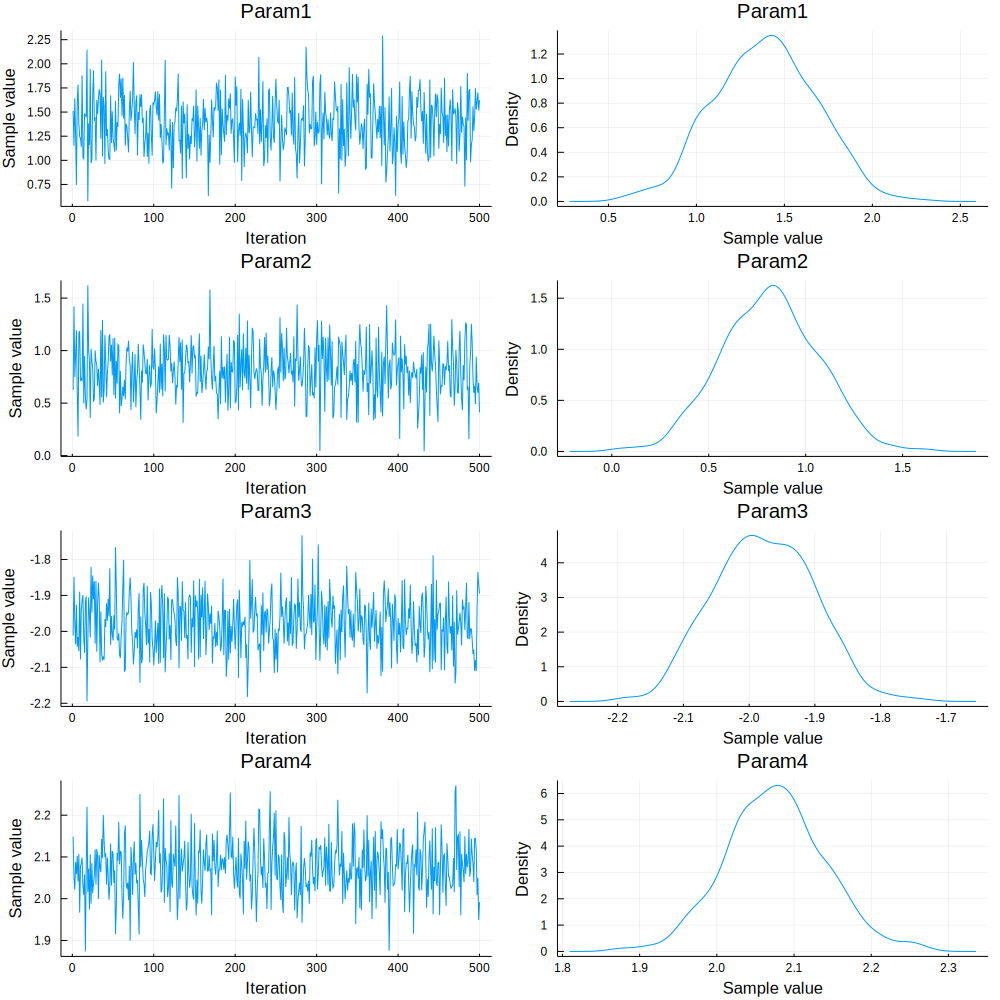

In [15]:
β_pos_sam = Array{Float64, 3}(undef, N_sam, p * q, 1);
β_pos_sam[:, :, 1] = hcat(β_sam[1, 1, :], β_sam[1, 2, :], β_sam[2, 1, :], β_sam[2, 2, :]);
β_chain = Chains(β_pos_sam);
pβ = plot(β_chain)

In [16]:
β

2×2 Array{Float64,2}:
  1.0  1.0
 -2.0  2.0

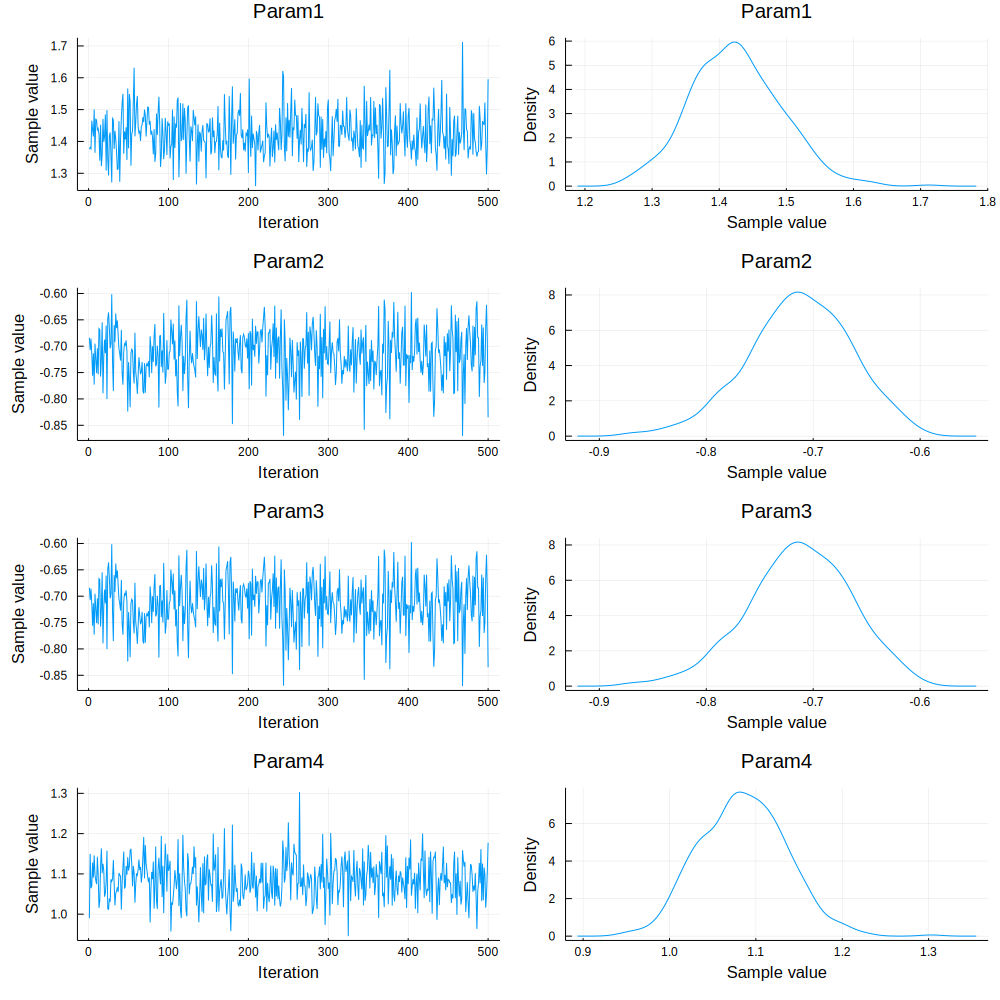

In [17]:
truncindex = 1;#Integer(trunc(N_sam / 2));
Σ_pos_sam = Array{Float64, 3}(undef, N_sam - truncindex + 1, q * q, 1);
Σ_pos_sam[:, :, 1] = hcat(Σ_sam[1, 1, truncindex:N_sam], Σ_sam[1, 2, truncindex:N_sam], 
    Σ_sam[2, 1, truncindex:N_sam], Σ_sam[2, 2, truncindex:N_sam]);
Σ_chain = Chains(Σ_pos_sam);
pΣ = plot(Σ_chain)

In [18]:
Σ

2×2 Array{Float64,2}:
  2.0  -1.0
 -1.0   1.5

# Posterior Inference 

In [19]:
# CVG # 
N_Inf_burn = 1;
Y_M_pos_qt = Array{Float64, 3}(undef, nm, q, 3);
Y_M_pos_mean = Array{Float64, 2}(undef, nm, q);
for j in 1:q
    for i in 1:nm
        Y_M_pos_qt[i, j, :] = quantile(Y_M_sam[i, j, N_Inf_burn:N_sam], [0.025, 0.5, 0.975]);
        Y_M_pos_mean[i, j] = mean(Y_M_sam[i, j, N_Inf_burn:N_sam])
    end
end
# count the covarage of 95% CI #
count = fill(0.0, 2);
for j in 1:q
    for i in 1:nm
        count[j] = count[j] + 
        ((Y_M_pos_qt[i, j, 1] < Y_ord[M[i], j]) && 
            (Y_M_pos_qt[i, j, 3] > Y_ord[M[i], j]))
    end
end
print(count ./ nm);
print(sum(count) / (q * nm))

[0.935, 0.955]0.945

In [20]:
# RMSPE #
MSPE1 = mean((Y_ord[M, 1] - Y_M_pos_mean[:, 1]).^2)
RMSPE1 = sqrt(MSPE1); 
MSPE2 = mean((Y_ord[M, 2] - Y_M_pos_mean[:, 2]).^2)
RMSPE2 = sqrt(MSPE2);
MSPE = mean((Y_ord[M, :] - Y_M_pos_mean).^2)
RMSPE = sqrt(MSPE);
round.([RMSPE1 RMSPE2 RMSPE], digits = 3)

1×3 Array{Float64,2}:
 0.727  0.602  0.668

In [21]:
Y_M_sam_var = [var(Y_M_sam[i, j, :]) for i in 1:nm, j in 1:q];
Y_M_sam_mean = [mean(Y_M_sam[i, j, :]) for i in 1:nm, j in 1:q];

In [22]:
CRPS_M = [(sqrt(Y_M_sam_var[i, j]) * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (Y_ord[M[i], j] - Y_M_sam_mean[i, j]) / sqrt(Y_M_sam_var[i, j])) -
        ((Y_ord[M[i], j] - Y_M_sam_mean[i, j]) / sqrt(Y_M_sam_var[i, j])) * 
        (2* cdf(Normal(), (Y_ord[M[i], j] - Y_M_sam_mean[i, j]) / sqrt(Y_M_sam_var[i, j])) - 1)))
        for i in 1:nm, j in 1:q];
round.([mean(CRPS_M[:, 1]) mean(CRPS_M[:, 2]) mean(CRPS_M)], digits = 3)

1×3 Array{Float64,2}:
 -0.408  -0.336  -0.372

In [23]:
INT_M = [((Y_M_pos_qt[i, j, 3] - Y_M_pos_qt[i, j, 1])+ 
                (2 / 0.05)*(Y_M_pos_qt[i, j, 1] - Y_ord[M[i], j]) * 
                (Y_ord[M[i], j] < Y_M_pos_qt[i, j, 1]) + 
                (2 / 0.05)*(Y_ord[M[i], j] - Y_M_pos_qt[i, j, 3]) * 
                (Y_ord[M[i], j] > (Y_M_pos_qt[i, j, 3]))) for i in 1:nm, j in 1:q];
round.([mean(INT_M[:, 1]) mean(INT_M[:, 2]) mean(INT_M)], digits = 3)

1×3 Array{Float64,2}:
 3.363  2.782  3.073

In [24]:
N_Inf_burn = 1;
summary_table = Array{Float64, 2}(undef, 7, 5);
summary_table[1, :] = vcat(β[1, 1], mean(β_sam[1, 1, N_Inf_burn:N_sam]),
    quantile(β_sam[1, 1, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[2, :] = vcat(β[1, 2], mean(β_sam[1, 2, N_Inf_burn:N_sam]),
    quantile(β_sam[1, 2, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[3, :] = vcat(β[2, 1], mean(β_sam[2, 1, N_Inf_burn:N_sam]),
    quantile(β_sam[2, 1, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[4, :] = vcat(β[2, 2], mean(β_sam[2, 2, N_Inf_burn:N_sam]),
    quantile(β_sam[2, 2, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[5, :] = vcat((1 / α - 1.0) * Σ[1, 1], mean((1 / α_pick - 1.0) .* Σ_sam[1, 1, N_Inf_burn:N_sam]),
    quantile((1 / α_pick - 1.0) .* Σ_sam[1, 1, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[6, :] = vcat((1 / α - 1.0) * Σ[2, 2], mean((1 / α_pick - 1.0) .* Σ_sam[2, 2, N_Inf_burn:N_sam]),
    quantile((1 / α_pick - 1.0) .* Σ_sam[2, 2, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[7, :] = vcat((1 / α - 1.0) * Σ[2, 1], mean((1 / α_pick - 1.0) .* Σ_sam[2, 1, N_Inf_burn:N_sam]),
    quantile((1 / α_pick - 1.0) .* Σ_sam[2, 1, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table = round.(summary_table; digits = 3);
rnames = ["β[1, 1]", "β[1, 2]", "β[2, 1]", "β[2, 2]", "(1/α - 1)Σ[1, 1]", "(1/α - 1)Σ[2, 2]", "(1/α - 1)Σ[1, 2]"];
summary_table = [rnames summary_table];
pretty_table(summary_table,  ["" "true" "mean" "median" "2.5%" "97.5%"], markdown)

┌ Warning: pretty_table(data, header, tf; kwargs...) is deprecated. Please, use pretty_table(data, header; tf = tf, kwargs...)
└ @ PrettyTables /home/luzhang/.julia/packages/PrettyTables/toFdC/src/deprecations.jl:20


|                  |   true |   mean | median |   2.5% |  97.5% |
|------------------|--------|--------|--------|--------|--------|
|          β[1, 1] |    1.0 |  1.391 |  1.399 |  0.814 |  1.902 |
|          β[1, 2] |    1.0 |  0.813 |  0.809 |  0.344 |  1.286 |
|          β[2, 1] |   -2.0 | -1.978 | -1.977 | -2.114 | -1.841 |
|          β[2, 2] |    2.0 |  2.076 |  2.076 |  1.952 |   2.21 |
| (1/α - 1)Σ[1, 1] |  0.222 |  0.226 |  0.225 |  0.205 |  0.248 |
| (1/α - 1)Σ[2, 2] |  0.167 |  0.172 |  0.172 |  0.158 |  0.188 |
| (1/α - 1)Σ[1, 2] | -0.111 | -0.113 | -0.113 | -0.129 | -0.099 |


In [25]:
@save "../results/Multi_conj_resp_data.jld" β_sam Σ_sam Y_M_sam